In [228]:
import numpy as np
import libpysal as ps
import missingno as msno
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
import lightgbm as lgbm

mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

In [229]:
acc_data = pd.read_csv('./집계구_안전지수_최종.csv',encoding="EUC-KR")
seoul_shp = gp.read_file('./data/서울시 행정구역 및 집계구 정보(SHP)/서울시_집계구_4326.shp',encoding="EUC-KR")
# pop_data = pd.read_csv('./data/pop/19년 12월 집계구코드별 평균생활인구수.csv')

In [230]:
acc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19153 entries, 0 to 19152
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TOT_REG_CD  19153 non-null  int64  
 1   ADM_NM      19153 non-null  object 
 2   ADM_CD      19153 non-null  int64  
 3   버스정류장       19153 non-null  int64  
 4   버스승하차       19153 non-null  int64  
 5   지하철(1km     19153 non-null  int64  
 6   지하철 거리점수    19153 non-null  int64  
 7   승하차평균       19153 non-null  int64  
 8   구별총생활       19153 non-null  int64  
 9   구별총생_1      19153 non-null  float64
 10  사고수n        8628 non-null   float64
 11  차선수         4306 non-null   float64
 12  평균속도        4306 non-null   float64
 13  표준편차        4306 non-null   float64
 14  혼잡수치        4306 non-null   float64
dtypes: float64(6), int64(8), object(1)
memory usage: 2.2+ MB


In [231]:
seoul_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19153 entries, 0 to 19152
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   TOT_REG_CD  19153 non-null  object  
 1   ADM_NM      19153 non-null  object  
 2   ADM_CD      19153 non-null  object  
 3   geometry    19153 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 598.7+ KB


In [232]:
seoul_shp.to_crs(epsg=4326)
seoul_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Column명 변경
- 지하철(1km -> SUB_NUM
- 지하철 거리점수 -> SUB_DIS_POINT
- 버스정류장 -> BUS_NUM
- 버스승하차 -> BUS_AVG
- 승하차평균 -> SUB_AVG
- 구별총생활 -> TOT_POP_GU
- 구별총생_1 -> TOT_POP_GU_AVG
- 사고수 -> ACC_NUM
- 차선수 -> LOAD_NUM
- 평균속도 -> SPEED_AVG
- 표준편차 -> SPEED_STD
- 혼잡수치 -> CONGESTION

TARGET VARIABLE : ACC_NUM

In [233]:
acc_data.columns

Index(['TOT_REG_CD', 'ADM_NM', 'ADM_CD', '버스정류장', '버스승하차', '지하철(1km',
       '지하철 거리점수', '승하차평균', '구별총생활', '구별총생_1', '사고수n', '차선수', '평균속도', '표준편차',
       '혼잡수치'],
      dtype='object')

In [234]:
acc_data.rename(columns={'지하철(1km':'SUB_NUM','지하철 거리점수':'SUB_DIS_POINT'
                         ,'버스정류장':'BUS_NUM','버스승하차':'BUS_AVG','승하차평균':'SUB_AVG'
                         ,'구별총생활':'TOT_POP_GU','구별총생_1':'TOT_POP_GU_AVG','사고수n':'ACC_NUM'
                        , '차선수':'LOAD_NUM','평균속도':'SPEED_AVG','표준편차':'SPEED_STD'
                        , '혼잡수치':'CONGESTION'},inplace=True)      
acc_data.columns

Index(['TOT_REG_CD', 'ADM_NM', 'ADM_CD', 'BUS_NUM', 'BUS_AVG', 'SUB_NUM',
       'SUB_DIS_POINT', 'SUB_AVG', 'TOT_POP_GU', 'TOT_POP_GU_AVG', 'ACC_NUM',
       'LOAD_NUM', 'SPEED_AVG', 'SPEED_STD', 'CONGESTION'],
      dtype='object')

### Column 생성
1. 면적 당 상가 수 = 상가 수 / 면적
2. 면적 당 시설 수 = 시설 수(어린이집, 공공기관, 보육시설, SOC_NUM) / 면적
3. 면적 당 버스정류장 = 정류장수 / 면적
4. 면적 당 지하철 수 = 지하철 수 / 면적
5. 면적 당 생활인구 수 = 구별총생활인구수 평균 / 면적

### 데이터 분포 확인 및 결측치 제거
#### 1. 지하철 거리 점수

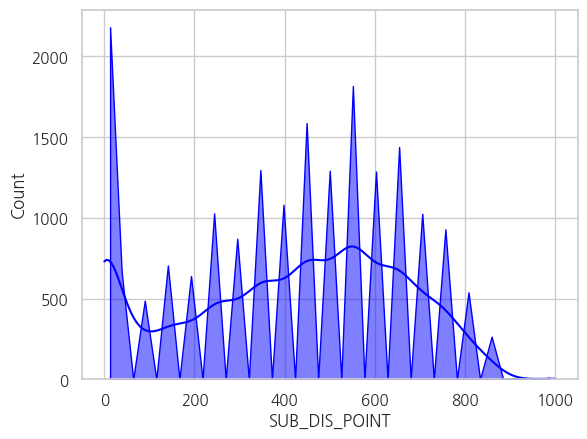

In [126]:
# standard scaler 적용
sns.histplot(data=acc_data,x='SUB_DIS_POINT',color='blue',kde=True, element='poly')
plt.show()

#### 2. 버스 승하차 평균
- 왼쪽으로 치우친 형태의 분포를 띄고 있다. 
- log함수를 이용하여 skew된 분포를 정규분포형태로 만들어주자.

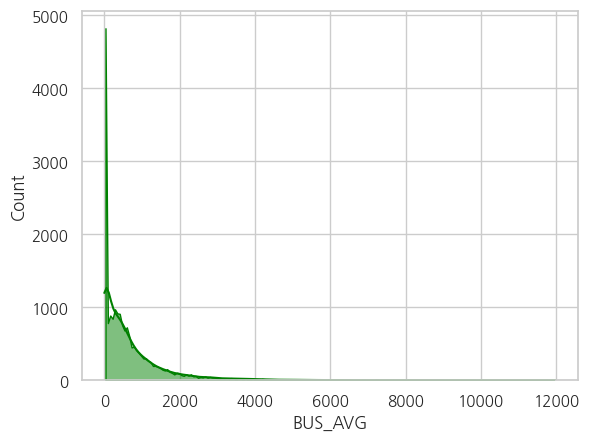

In [127]:
sns.histplot(data=acc_data,x='BUS_AVG',element="poly",color='green',kde=True)
plt.show()

#### 3. 지하철 승하차 평균
- 왼쪽으로 치우친 분포를 보이고 있다.
- log함수를 이용하여 정규분포 형태를 만들어주자.

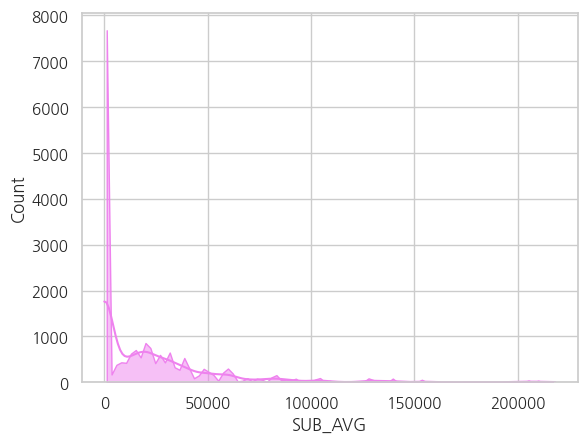

In [128]:
sns.histplot(data=acc_data,x='SUB_AVG',color='violet',element="poly",kde=True)
plt.show()

#### 4. 1km 내 지하철 역 수

- 일단 log 씌워주자

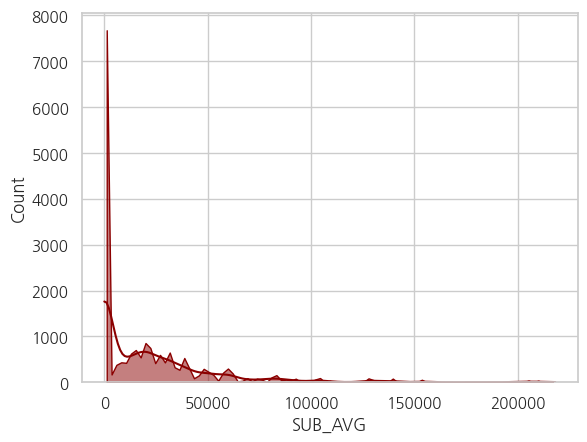

In [129]:
sns.histplot(data=acc_data,x='SUB_AVG',color='darkred',element="poly",kde=True)
plt.show()

#### 5. 구별총생활인구수 평균

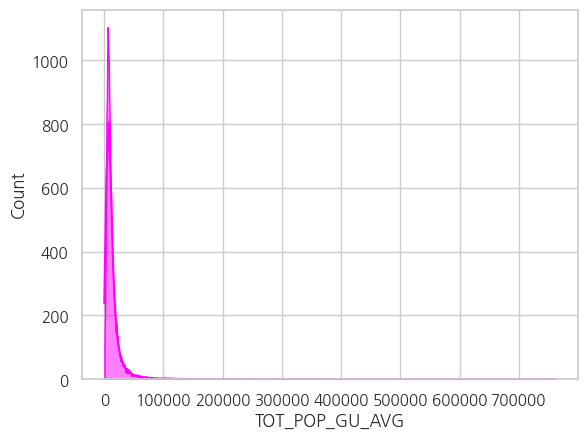

In [130]:
sns.histplot(data=acc_data,x='TOT_POP_GU_AVG',color='magenta',element="poly",kde=True)
plt.show()

- 사고수n, 차선수, 평균속도, 표준편차, 혼잡수치에 결측치가 존재한다.
- 사고수n : 0으로 대체한다.
- 차선수 : 1로 대체한다.
- 평균속도 : 평균속도의 분포를 살펴보고 평균으로 대체할 수 있도록 한다.
- 표준편차 : 혼잡수치의 산출에 필요한 데이터이므로 column을 제거하도록한다.
- 혼잡수치 : 혼잡수치의 평균으로 대체할 수 있도록 한다.

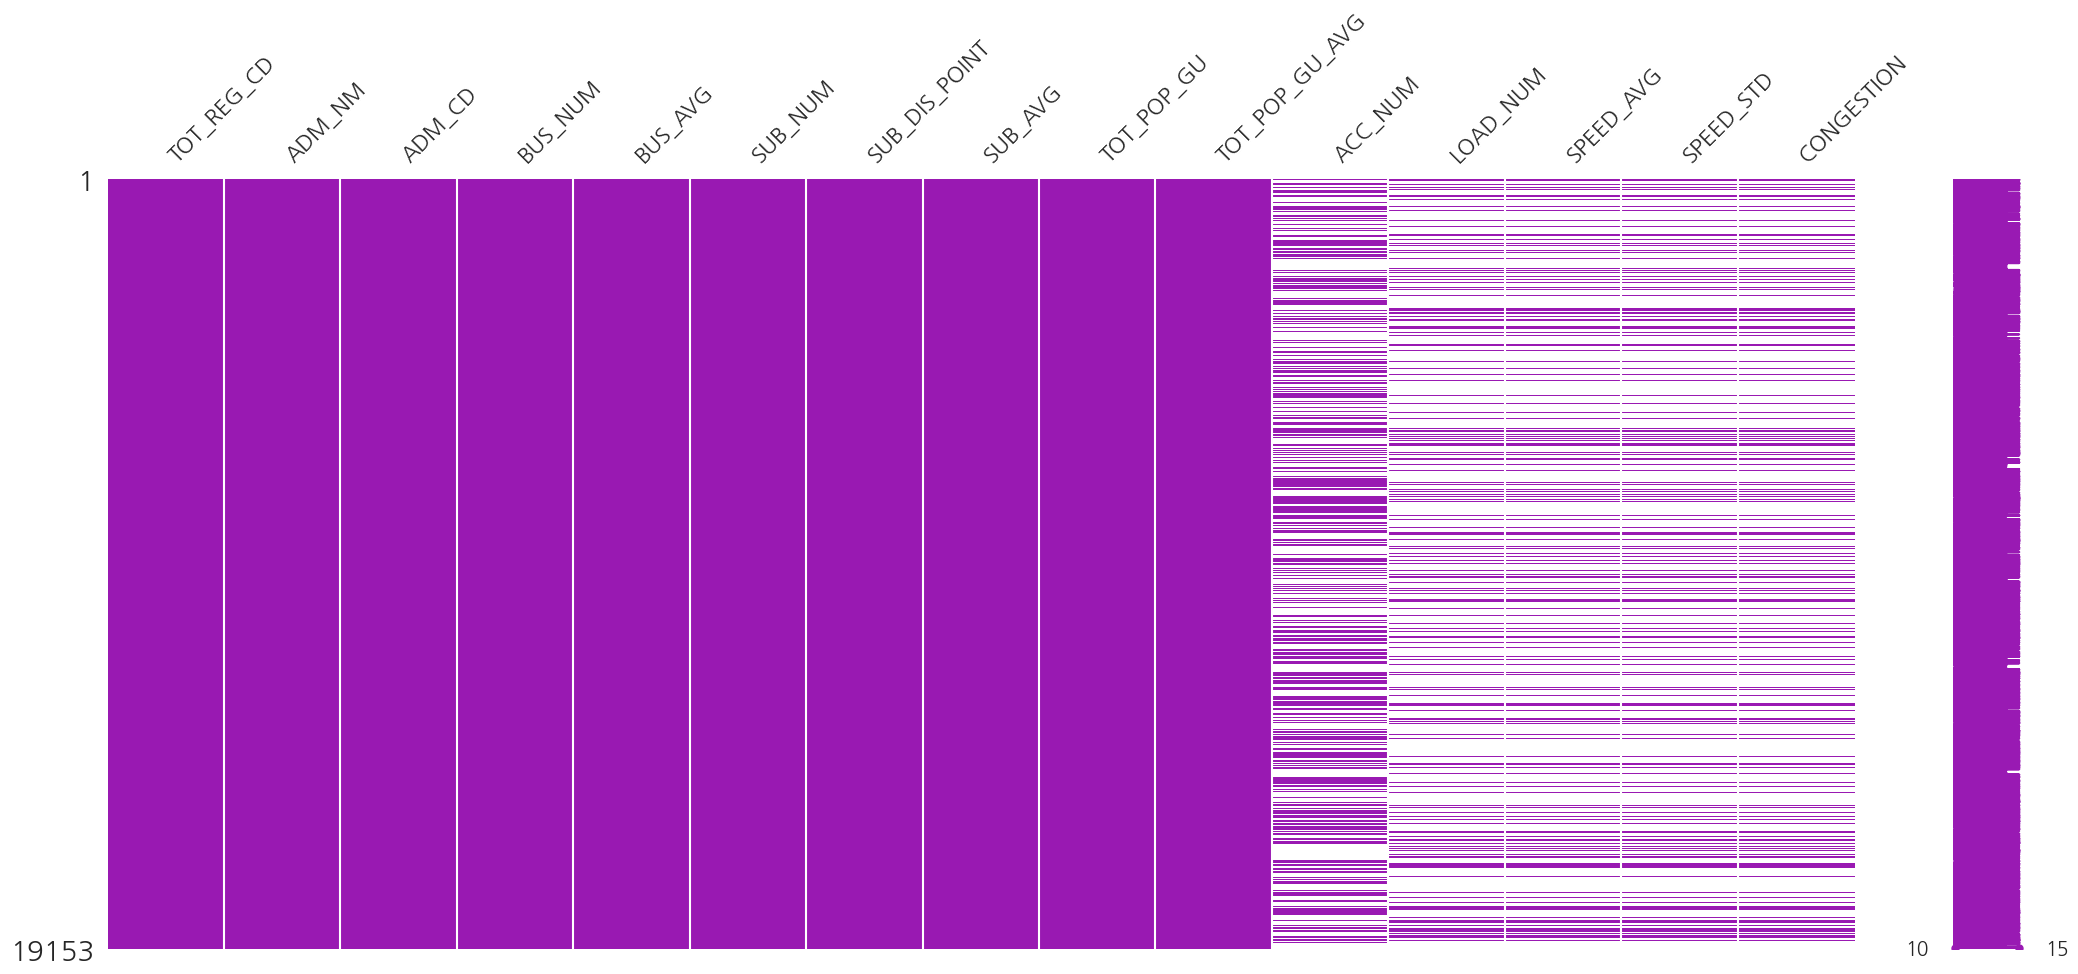

In [235]:
msno.matrix(df=acc_data,color=(0.6,0.1,0.7))
plt.show()

In [236]:
acc_data.isnull().sum()

TOT_REG_CD            0
ADM_NM                0
ADM_CD                0
BUS_NUM               0
BUS_AVG               0
SUB_NUM               0
SUB_DIS_POINT         0
SUB_AVG               0
TOT_POP_GU            0
TOT_POP_GU_AVG        0
ACC_NUM           10525
LOAD_NUM          14847
SPEED_AVG         14847
SPEED_STD         14847
CONGESTION        14847
dtype: int64

### 사고 수와 혼잡지수의 교집합 계산

In [337]:
# 사고 수와 혼잡지수 둘 다 null이 아는 row들만 추출하여 모델을 생성
intersect_data = acc_data[~(acc_data['ACC_NUM'].isna() | acc_data['CONGESTION'].isna())]
prediction_data = acc_data[acc_data['ACC_NUM'].isna() & ~acc_data['CONGESTION'].isna()]
empty_data = acc_data[acc_data['ACC_NUM'].isna() & acc_data['CONGESTION'].isna()]
len(empty_data)

8415

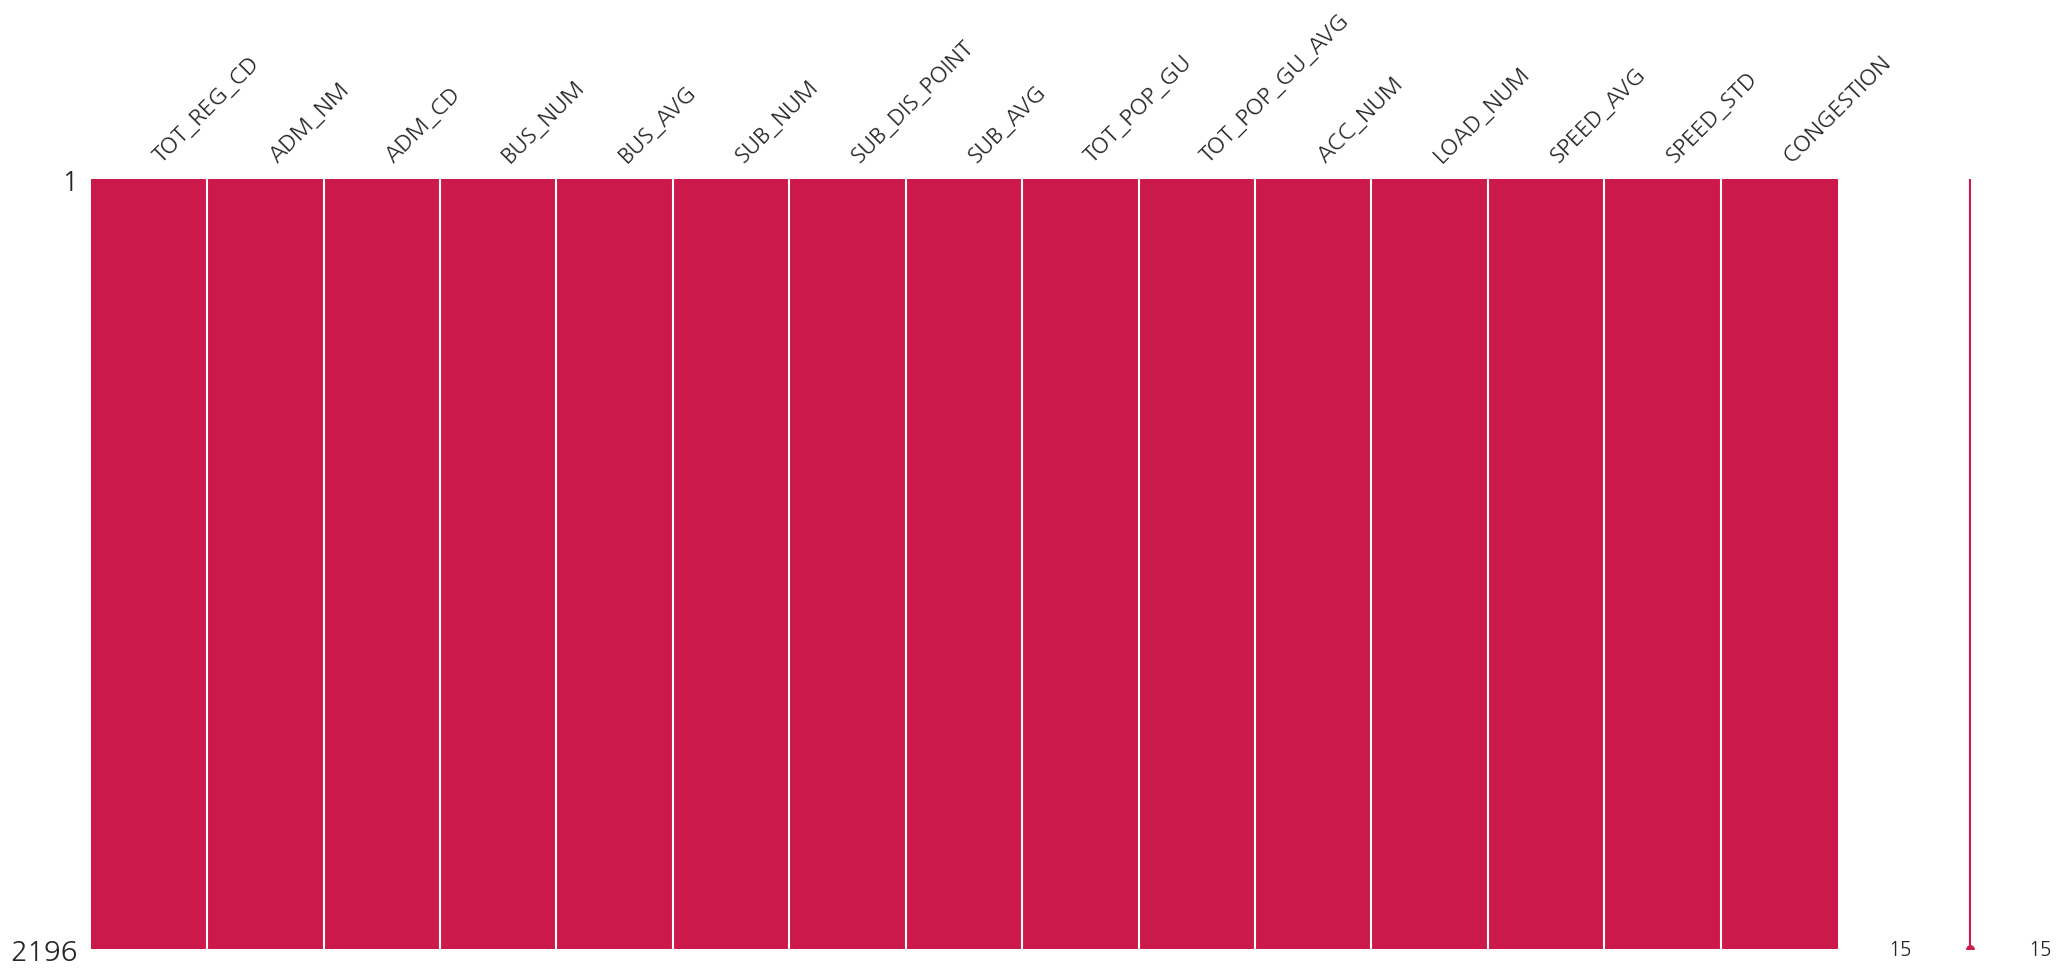

In [238]:
msno.matrix(df=intersect_data,color=(0.8,0.1,0.3))
plt.show()

In [239]:
intersect_data.isnull().sum()

TOT_REG_CD        0
ADM_NM            0
ADM_CD            0
BUS_NUM           0
BUS_AVG           0
SUB_NUM           0
SUB_DIS_POINT     0
SUB_AVG           0
TOT_POP_GU        0
TOT_POP_GU_AVG    0
ACC_NUM           0
LOAD_NUM          0
SPEED_AVG         0
SPEED_STD         0
CONGESTION        0
dtype: int64

#### 1. 사고수

In [133]:
avg_acc_data = acc_data['ACC_NUM'].agg(['min','max','mean','std','median'])
avg_acc_data

min         1.000000
max       104.000000
mean        5.027005
std         6.535054
median      3.000000
Name: ACC_NUM, dtype: float64

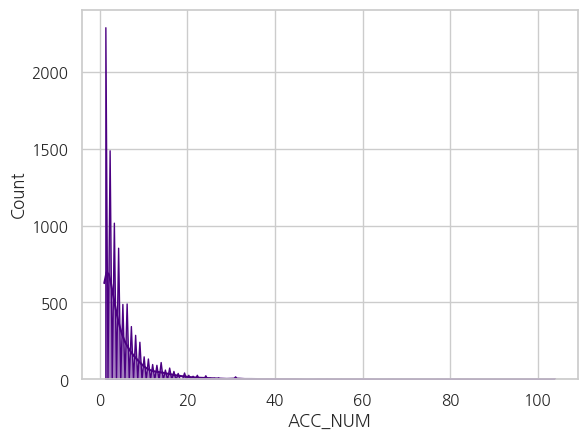

In [134]:
sns.histplot(data=acc_data,x='ACC_NUM',color='indigo',element='poly',kde=True)
plt.show()

In [135]:
Q1 = acc_data['ACC_NUM'].quantile(.25)
Q2 = acc_data['ACC_NUM'].quantile(.5)
Q3 = acc_data['ACC_NUM'].quantile(.75)
display(Q1)
display(Q2)
display(Q3)

1.0

3.0

6.0

일단 2분위수로 대체한다.

In [136]:
# 2분위수로 대체
acc_data['ACC_NUM'].fillna(Q2,inplace=True)
acc_data['ACC_NUM'].isnull().sum()

0

#### 2. 차선수

In [137]:
load_agg = acc_data['LOAD_NUM'].agg(['min','max','mean','std'])
load_agg

min     1.000000
max     7.000000
mean    2.423027
std     0.905411
Name: LOAD_NUM, dtype: float64

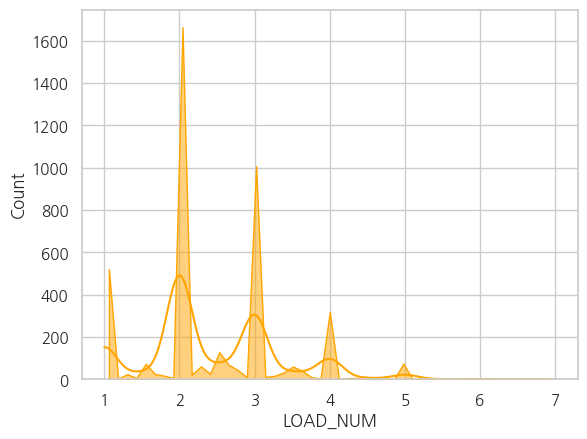

In [138]:
sns.histplot(data=acc_data,x='LOAD_NUM',color='orange',element='poly',kde=True)
plt.show()

In [140]:
# 평균값으로 대체
acc_data['LOAD_NUM'].fillna(load_agg['mean'],inplace=True)
acc_data['LOAD_NUM'].isnull().sum()

0

#### 3. 차량 속도

In [141]:
speed_avg_agg = acc_data['SPEED_AVG'].agg(['min','max','mean','std'])
speed_avg_agg

min     11.558014
max     63.232875
mean    24.564157
std      5.972924
Name: SPEED_AVG, dtype: float64

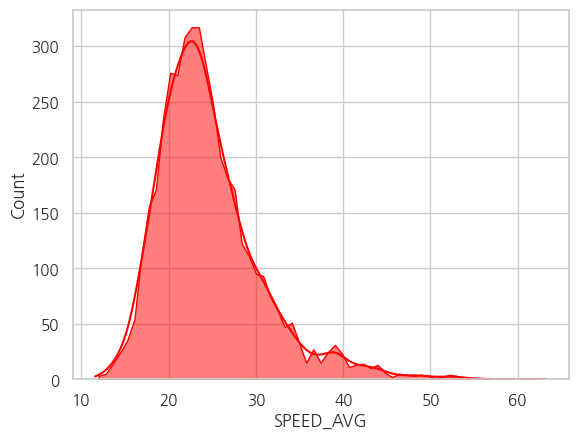

In [142]:
# standard scaler
sns.histplot(data=acc_data,x='SPEED_AVG',color='red',element='poly',kde=True)
plt.show()

In [143]:
acc_data['SPEED_AVG'].fillna(speed_avg_agg['mean'],inplace=True)
acc_data['SPEED_AVG'].isnull().sum()

0

#### 4. 혼잡수치

In [144]:
congestion_agg = acc_data['CONGESTION'].agg(['min','max','mean','std'])
congestion_agg

min      -63.254026
max     2944.321667
mean    2159.331917
std      401.982179
Name: CONGESTION, dtype: float64

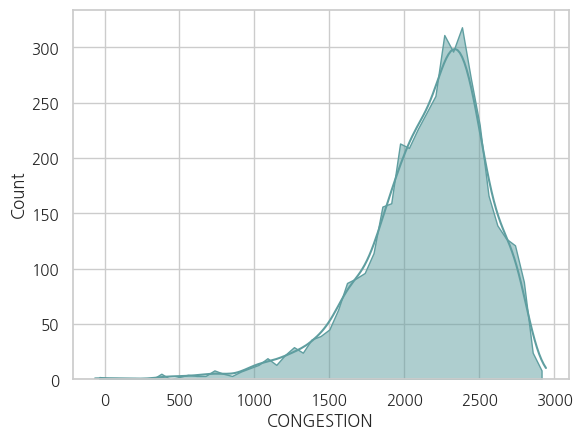

In [145]:
# standard scaler 적용.
sns.histplot(data=acc_data,x='CONGESTION',color='cadetblue',element='poly',kde=True)
plt.show()

- 0보다 작은 수들은 0으로 대체한다.
- 마찬가지로 minmaxscaler를 사용한다.
- 음수값들을 0으로 대체하고 분포를 다시 살펴본 후 null값을 대체하자.

In [146]:
acc_data.loc[acc_data['CONGESTION'] < 0,'CONGESTION'] = 0
speed_avg_agg = acc_data['CONGESTION'].agg(['min','max','mean','std'])
speed_avg_agg

min        0.000000
max     2944.321667
mean    2159.350105
std      401.883223
Name: CONGESTION, dtype: float64

In [240]:
intersect_data.loc[intersect_data['CONGESTION']<0,'CONGESTION'] = 0
intersect_data['CONGESTION'].agg(['min','max'])

min       0.00000
max    2912.24125
Name: CONGESTION, dtype: float64

In [72]:
acc_data['CONGESTION'].fillna(speed_avg_agg['mean'],inplace=True)
acc_data['CONGESTION'].isnull().sum()

0

In [87]:
acc_data.isnull().sum()

TOT_REG_CD            0
ADM_NM                0
ADM_CD                0
BUS_NUM               0
BUS_AVG               0
SUB_NUM               0
SUB_DIS_POINT         0
SUB_AVG               0
TOT_POP_GU            0
TOT_POP_GU_AVG        0
ACC_NUM               0
LOAD_NUM              0
SPEED_AVG             0
SPEED_STD         14847
CONGESTION            0
dtype: int64

### Merge shp data and accident data

In [241]:
# 현재 TOT_REG_CD가 int type이므로 str type으로 변경해주도록 한다.
# 차후 merge를 하기 위해서이다.
intersect_data['TOT_REG_CD']= intersect_data['TOT_REG_CD'].astype(str)

In [242]:
# prepare dataset
data = intersect_data.merge(seoul_shp,left_on='TOT_REG_CD',right_on='TOT_REG_CD')
data.head()

,TOT_REG_CD,ADM_NM_x,ADM_CD_x,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS_POINT,SUB_AVG,TOT_POP_GU,TOT_POP_GU_AVG,ACC_NUM,LOAD_NUM,SPEED_AVG,SPEED_STD,CONGESTION,ADM_NM_y,ADM_CD_y,geometry
0,1101053010003,사직동,1101053,13,492,4,400,34690,1245899,40190.29032,4.0,1.750000,34.777229,2.489154,1915.480185,사직동,1101053,"POLYGON ((126.96645 37.57883, 126.96647 37.578..."
1,1101053010005,사직동,1101053,7,2165,3,700,52315,1038484,33499.48387,2.0,2.000000,20.479500,2.667286,2431.128400,사직동,1101053,"POLYGON ((126.97399 37.57823, 126.97400 37.578..."
2,1101053020002,사직동,1101053,28,2505,8,550,65488,9685760,312443.87100,50.0,3.130435,24.694380,4.760363,1994.767706,사직동,1101053,"POLYGON ((126.97420 37.57578, 126.97425 37.575..."
3,1101053020001,사직동,1101053,0,0,6,700,66004,1506501,48596.80645,20.0,2.500000,23.463493,3.483531,2187.431030,사직동,1101053,"POLYGON ((126.97448 37.57409, 126.97459 37.573..."
4,1101053020304,사직동,1101053,3,1469,4,500,52315,314179,10134.80645,8.0,2.000000,22.160229,3.823399,2359.821101,사직동,1101053,"POLYGON ((126.96910 37.57462, 126.96860 37.574..."


In [319]:
data.columns

Index(['TOT_REG_CD', 'ADM_NM_x', 'ADM_CD_x', 'BUS_NUM', 'BUS_AVG', 'SUB_NUM',
       'SUB_DIS_POINT', 'SUB_AVG', 'TOT_POP_GU', 'TOT_POP_GU_AVG', 'ACC_NUM',
       'LOAD_NUM', 'SPEED_AVG', 'SPEED_STD', 'CONGESTION', 'ADM_NM_y',
       'ADM_CD_y', 'geometry'],
      dtype='object')

In [320]:
essential_col=['TOT_REG_CD','BUS_NUM','BUS_AVG','SUB_NUM','SUB_DIS_POINT','SUB_AVG'
               ,'TOT_POP_GU_AVG','LOAD_NUM','SPEED_AVG','CONGESTION','geometry','ACC_NUM']
required_data = data.loc[:,essential_col]
required_data.head()

,TOT_REG_CD,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS_POINT,SUB_AVG,TOT_POP_GU_AVG,LOAD_NUM,SPEED_AVG,CONGESTION,geometry,ACC_NUM
0,1101053010003,13,492,4,400,34690,40190.29032,1.750000,34.777229,1915.480185,"POLYGON ((126.96645 37.57883, 126.96647 37.578...",4.0
1,1101053010005,7,2165,3,700,52315,33499.48387,2.000000,20.479500,2431.128400,"POLYGON ((126.97399 37.57823, 126.97400 37.578...",2.0
2,1101053020002,28,2505,8,550,65488,312443.87100,3.130435,24.694380,1994.767706,"POLYGON ((126.97420 37.57578, 126.97425 37.575...",50.0
3,1101053020001,0,0,6,700,66004,48596.80645,2.500000,23.463493,2187.431030,"POLYGON ((126.97448 37.57409, 126.97459 37.573...",20.0
4,1101053020304,3,1469,4,500,52315,10134.80645,2.000000,22.160229,2359.821101,"POLYGON ((126.96910 37.57462, 126.96860 37.574...",8.0


### Data 분포 변환

#### 1. 버스 이용객 평균

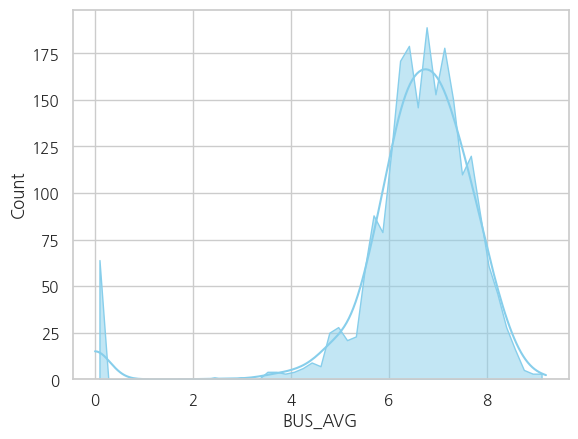

In [303]:
required_data.loc[:,'BUS_AVG'] = np.log1p(data['BUS_AVG'])
sns.histplot(data=required_data,x='BUS_AVG',color='skyblue',element="poly",kde=True)
plt.show()

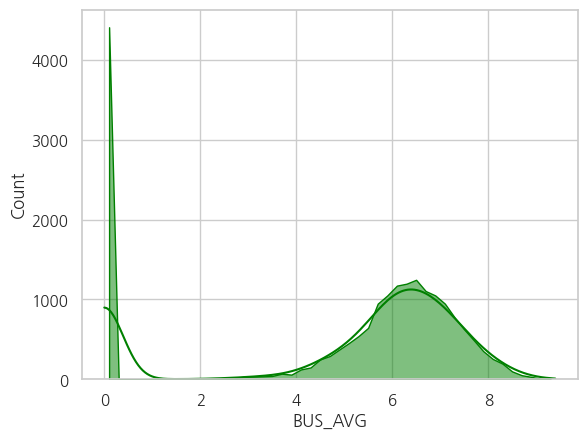

In [93]:
required_data.loc[:,'BUS_AVG'] = np.log1p(data['BUS_AVG'])
sns.histplot(data=required_data,x='BUS_AVG',element="poly",color='green',kde=True)
plt.show()

#### 2. 지하철 이용객 평균

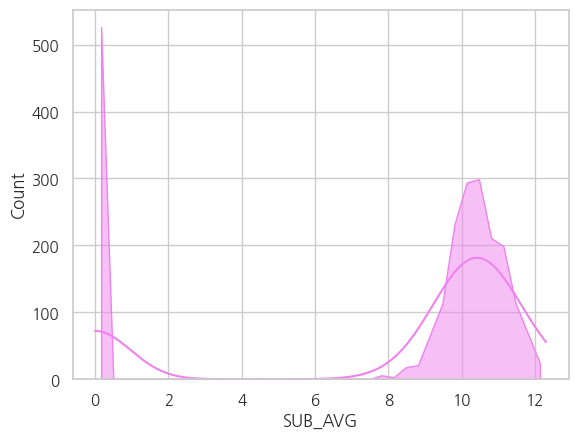

In [305]:
required_data.loc[:,'SUB_AVG'] = np.log1p(data['SUB_AVG'])
sns.histplot(data=required_data,x='SUB_AVG',color='violet',element="poly",kde=True)
plt.show()

#### 3. 구별 총 생활인구 평균

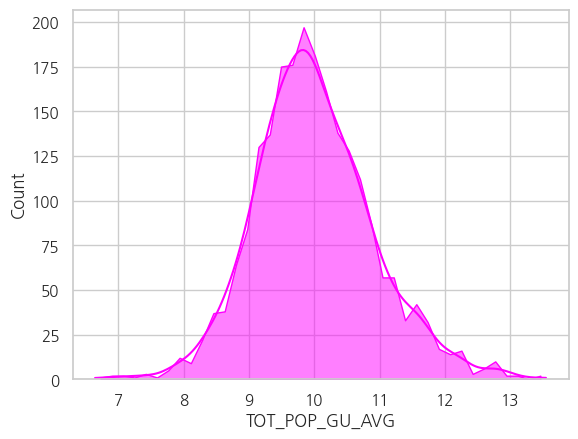

In [306]:
required_data.loc[:,'TOT_POP_GU_AVG'] = np.log1p(data['TOT_POP_GU_AVG'])
sns.histplot(data=required_data,x='TOT_POP_GU_AVG',color='magenta',element="poly",kde=True)
plt.show()

#### 4. 지하철 거리 점수

In [307]:
sd_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

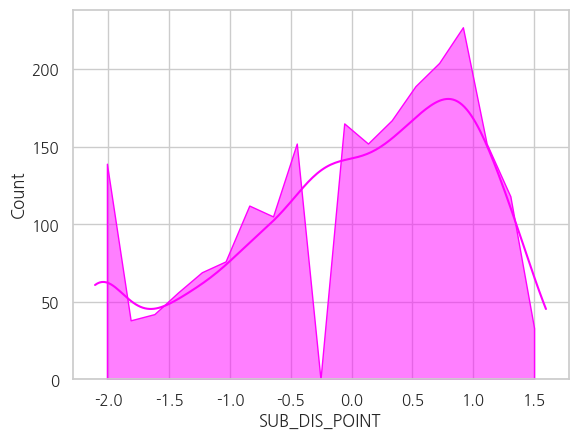

In [308]:
sub_dis_point = required_data.loc[:,'SUB_DIS_POINT'].values.reshape((-1,1))
required_data.loc[:,'SUB_DIS_POINT'] = pd.Series(sd_scaler.fit_transform(sub_dis_point).flatten())
sns.histplot(data=required_data,x='SUB_DIS_POINT',color='magenta',element="poly",kde=True)
plt.show()

#### 5. 속도 평균

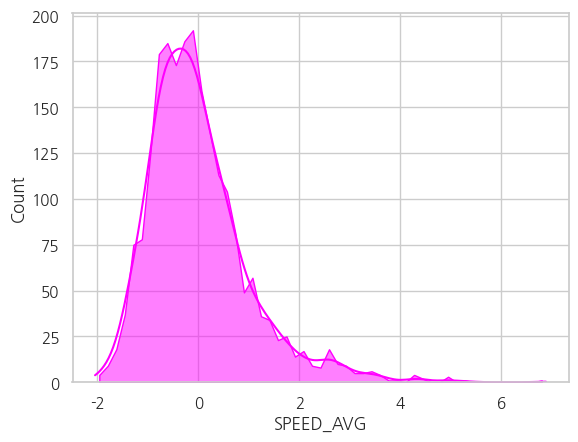

In [309]:
sub_dis_point = required_data.loc[:,'SPEED_AVG'].values.reshape((-1,1))
required_data.loc[:,'SPEED_AVG'] = pd.Series(sd_scaler.fit_transform(sub_dis_point).flatten())
sns.histplot(data=required_data,x='SPEED_AVG',color='magenta',element="poly",kde=True)
plt.show()

#### 6. 혼잡지수

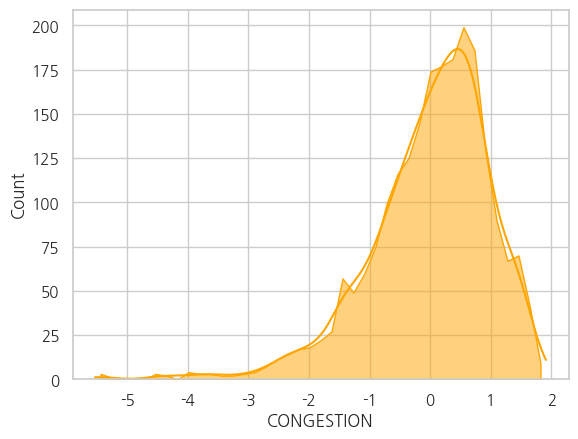

In [310]:
sub_dis_point = required_data.loc[:,'CONGESTION'].values.reshape((-1,1))
required_data.loc[:,'CONGESTION'] = pd.Series(sd_scaler.fit_transform(sub_dis_point).flatten())
sns.histplot(data=required_data,x='CONGESTION',color='orange',element="poly",kde=True)
plt.show()

In [321]:
center = seoul_shp.centroid
X = pd.Series(center.x)
Y = pd.Series(center.y)
required_data.loc[:,'lon'] = X
required_data.loc[:,'lat'] = Y
required_data.head()

,TOT_REG_CD,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS_POINT,SUB_AVG,TOT_POP_GU_AVG,LOAD_NUM,SPEED_AVG,CONGESTION,geometry,ACC_NUM,lon,lat
0,1101053010003,13,492,4,400,34690,40190.29032,1.750000,34.777229,1915.480185,"POLYGON ((126.96645 37.57883, 126.96647 37.578...",4.0,126.970311,37.578304
1,1101053010005,7,2165,3,700,52315,33499.48387,2.000000,20.479500,2431.128400,"POLYGON ((126.97399 37.57823, 126.97400 37.578...",2.0,126.965178,37.574151
2,1101053020002,28,2505,8,550,65488,312443.87100,3.130435,24.694380,1994.767706,"POLYGON ((126.97420 37.57578, 126.97425 37.575...",50.0,126.965513,37.576513
3,1101053020001,0,0,6,700,66004,48596.80645,2.500000,23.463493,2187.431030,"POLYGON ((126.97448 37.57409, 126.97459 37.573...",20.0,126.969002,37.577092
4,1101053020304,3,1469,4,500,52315,10134.80645,2.000000,22.160229,2359.821101,"POLYGON ((126.96910 37.57462, 126.96860 37.574...",8.0,126.972772,37.578025


### 독립변수, 종속변수 설정

In [322]:
essential_col[1:-2]

['BUS_NUM',
 'BUS_AVG',
 'SUB_NUM',
 'SUB_DIS_POINT',
 'SUB_AVG',
 'TOT_POP_GU_AVG',
 'LOAD_NUM',
 'SPEED_AVG',
 'CONGESTION']

In [323]:
#Prepare Georgia dataset inputs
s_y = required_data['ACC_NUM'].values.reshape((-1,1))
s_X = required_data[essential_col[1:-2]].values
u = required_data['lon']
v = required_data['lat']
s_coords = list(zip(u,v))

### Train and Test set 분리

In [58]:
s_y = sample_data['구별총생활인구수(월평균)'].values.reshape((-1,1))
s_X = sample_data[['정류장수', '월평균승차수', '월평균하차수','lon','lat']].values
u = sample_data['lon']
v = sample_data['lat']
coords = list(zip(u,v))

# standardScaler적용

# scaler = StandardScaler()
# s_y = required_data['TOT_POP_GU_AVG']
# s_X = required_data[['정류장수', '월평균승차수', '월평균하차수','lon','lat']]

# train set과 test set으로 나누는 과정으로 보인다.
# 해당 모델에 교차 검증이 있는 것으로 알고 있다.

# test set은 20%, 
# x_train, x_valid, y_train, y_valid = train_test_split(s_X, s_y, test_size=0.2, shuffle=True,random_state=34)

# cal_u = x_train['lon'].values
# cal_v = x_train['lat'].values
# cal_coords = list(zip(cal_u,cal_v))

# pred_u = x_valid['lon'].values
# pred_v = x_valid['lat'].values
# pred_coords = list(zip(pred_u,pred_v))

# # 위도, 경도 column 제거
# # display(x_train.columns)
# x_train.drop(['lon','lat'],axis=1,inplace=True)
# x_valid.drop(['lon','lat'],axis=1,inplace=True)

# # array로 변환
# X_train = scaler.fit_transform(x_train.values)
# Y_train = scaler.fit_transform(y_train.values.reshape((-1,1)))
# X_valid = scaler.fit_transform(x_valid.values)
# Y_valid = scaler.fit_transform(y_valid.values.reshape((-1,1)))

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Modeling

In [324]:
#Calibrate GWR model
gwr_selector = Sel_BW(s_coords, s_y, s_X,kernel='gaussian')
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y, s_X, gwr_bw,kernel='gaussian')
gwr_results = gwr_model.fit()

26.0


In [325]:
gwr_results.params[0:5]

array([[-9.02820935e+01, -2.18533375e-01,  1.44477794e-02,
        -1.57185651e+00, -6.69570553e-03,  4.81049886e-05,
         2.51621996e-05,  7.78617432e+00,  9.28513629e-01,
         2.41864544e-02],
       [-6.33155602e+01, -2.89976386e-01,  8.24022093e-03,
        -1.43060426e-01, -9.60812416e-03,  8.47192550e-05,
         7.67374022e-05,  5.20633770e+00,  4.75654409e-01,
         1.93375267e-02],
       [-1.05503005e+02, -2.73415507e-01,  1.23688774e-02,
        -2.23139075e-01, -1.54307533e-02,  1.08628388e-04,
         4.48693805e-05,  9.15842908e+00,  8.30317809e-01,
         3.05315500e-02],
       [-8.44264399e+01, -2.43667587e-01,  1.39934808e-02,
        -9.92524067e-01, -9.27676828e-03,  6.38227400e-05,
         3.31525906e-05,  7.16428748e+00,  7.86152146e-01,
         2.33140842e-02],
       [-1.48732890e+02, -1.40891061e-01,  9.25929767e-03,
        -2.00040206e+00, -3.99641215e-03,  9.88299732e-06,
         4.02142204e-05,  1.16639487e+01,  1.60807368e+00,
         4.

In [317]:
gwr_results.localR2[0:10]

array([[0.2522524 ],
       [0.25603334],
       [0.26269655],
       [0.25488944],
       [0.25136298],
       [0.25283365],
       [0.25517822],
       [0.25556202],
       [0.25459946],
       [0.25630154]])

### 모델링 결과 확인

In [326]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                2196
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         123929.510
Log-likelihood:                                                   -7544.306
AIC:                                                              15108.612
AICc:                                                             15110.733
BIC:                                                             107109.567
R2:                                                                   0.104
Adj. R2:                                                              0.100

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 예측 모델생성

In [338]:
#Prepare Georgia dataset inputs
col = essential_col[1:-2]
col.append('lon')
col.append('lat')

s_y = required_data['ACC_NUM']
s_X = required_data[col]

x_train, x_valid, y_train, y_valid = train_test_split(s_X, s_y, test_size=0.2, shuffle=True,random_state=34)

cal_u = x_train['lon'].values
cal_v = x_train['lat'].values
cal_coords = list(zip(cal_u,cal_v))

pred_u = x_valid['lon'].values
pred_v = x_valid['lat'].values
pred_coords = list(zip(pred_u,pred_v))

# 위도, 경도 column 제거
# display(x_train.columns)
x_train.drop(['lon','lat'],axis=1,inplace=True)
x_valid.drop(['lon','lat'],axis=1,inplace=True)

# array로 변환
X_train = x_train.values
Y_train = y_train.values.reshape((-1,1))
X_valid = x_valid.values
Y_valid = y_valid.values.reshape((-1,1))

In [339]:
#Calibrate GWR model
gwr_selector = Sel_BW(cal_coords, Y_train, X_train,kernel='gaussian')
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(cal_coords, Y_train, X_train, gwr_bw,kernel='gaussian')
gwr_results = gwr_model.fit()

34.0


In [340]:
scale = gwr_results.scale
residuals = gwr_results.resid_response
# 
display(type(pred_coords))
# test data로 예측을 해보고 결과 저장
pred_results = gwr_model.predict(np.array(pred_coords), X_valid, scale, residuals)

list

In [343]:
np.corrcoef(pred_results.predictions.flatten(), Y_valid.flatten())
# [0][1]

array([[1.        , 0.35423767],
       [0.35423767, 1.        ]])

### 사고수 예측

In [327]:
prediction_data

,TOT_REG_CD,ADM_NM,ADM_CD,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS_POINT,SUB_AVG,TOT_POP_GU,TOT_POP_GU_AVG,ACC_NUM,LOAD_NUM,SPEED_AVG,SPEED_STD,CONGESTION
5,1101053010004,사직동,1101053,7,3171,4,750,52315,1515584,48889.80645,NaN,3.000000,32.791486,4.466515,1656.517367
10,1101053020303,사직동,1101053,2,1913,4,450,52315,140275,4525.00000,NaN,2.000000,38.943069,3.217489,1647.785491
17,1101054010002,삼청동,1101054,12,272,2,100,0,1383156,44617.93548,NaN,1.000000,30.130532,2.977697,2396.084028
18,1101054010005,삼청동,1101054,7,333,1,50,0,560292,18073.93548,NaN,2.000000,22.318069,2.130019,2353.124505
22,1101055010001,부암동,1101055,6,1053,0,0,0,443237,14297.96774,NaN,2.500000,27.037361,3.160266,2018.607602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19036,1102070010004,다산동,1102070,4,1036,6,750,44695,369532,11920.38710,NaN,1.000000,18.880944,3.729693,2733.571667
19042,1102070010001,다산동,1102070,4,1280,7,700,25725,572360,18463.22581,NaN,4.000000,33.404625,3.674265,1295.722500
19044,1102070010002,다산동,1102070,5,1518,8,750,25725,1206103,38906.54839,NaN,3.000000,21.530028,4.723525,2181.266940
19046,1102070020006,다산동,1102070,7,1136,7,750,30710,690933,22288.16129,NaN,4.000000,26.265187,4.083251,1724.088750


In [328]:
prediction_data.loc[prediction_data['CONGESTION']<0,'CONGESTION'] = 0
prediction_data['CONGESTION'].agg(['min','max'])

min     225.138334
max    2944.321667
Name: CONGESTION, dtype: float64

In [329]:
# 현재 TOT_REG_CD가 int type이므로 str type으로 변경해주도록 한다.
# 차후 merge를 하기 위해서이다.
prediction_data['TOT_REG_CD']= prediction_data['TOT_REG_CD'].astype(str)

In [330]:
# prepare dataset
p_data = prediction_data.merge(seoul_shp,left_on='TOT_REG_CD',right_on='TOT_REG_CD')
p_data.head()

,TOT_REG_CD,ADM_NM_x,ADM_CD_x,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS_POINT,SUB_AVG,TOT_POP_GU,TOT_POP_GU_AVG,ACC_NUM,LOAD_NUM,SPEED_AVG,SPEED_STD,CONGESTION,ADM_NM_y,ADM_CD_y,geometry
0,1101053010004,사직동,1101053,7,3171,4,750,52315,1515584,48889.80645,NaN,3.0,32.791486,4.466515,1656.517367,사직동,1101053,"POLYGON ((126.97145 37.57734, 126.97147 37.577..."
1,1101053020303,사직동,1101053,2,1913,4,450,52315,140275,4525.00000,NaN,2.0,38.943069,3.217489,1647.785491,사직동,1101053,"POLYGON ((126.96891 37.57379, 126.96851 37.573..."
2,1101054010002,삼청동,1101054,12,272,2,100,0,1383156,44617.93548,NaN,1.0,30.130532,2.977697,2396.084028,삼청동,1101054,"POLYGON ((126.97714 37.59768, 126.97730 37.597..."
3,1101054010005,삼청동,1101054,7,333,1,50,0,560292,18073.93548,NaN,2.0,22.318069,2.130019,2353.124505,삼청동,1101054,"POLYGON ((126.98374 37.58675, 126.98383 37.586..."
4,1101055010001,부암동,1101055,6,1053,0,0,0,443237,14297.96774,NaN,2.5,27.037361,3.160266,2018.607602,부암동,1101055,"POLYGON ((126.96121 37.60445, 126.96136 37.604..."


In [331]:
essential_col=['TOT_REG_CD','BUS_NUM','BUS_AVG','SUB_NUM','SUB_DIS_POINT','SUB_AVG'
               ,'TOT_POP_GU_AVG','LOAD_NUM','SPEED_AVG','CONGESTION','geometry','ACC_NUM']
p_required_data = p_data.loc[:,essential_col]
p_required_data.head()

,TOT_REG_CD,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS_POINT,SUB_AVG,TOT_POP_GU_AVG,LOAD_NUM,SPEED_AVG,CONGESTION,geometry,ACC_NUM
0,1101053010004,7,3171,4,750,52315,48889.80645,3.0,32.791486,1656.517367,"POLYGON ((126.97145 37.57734, 126.97147 37.577...",NaN
1,1101053020303,2,1913,4,450,52315,4525.00000,2.0,38.943069,1647.785491,"POLYGON ((126.96891 37.57379, 126.96851 37.573...",NaN
2,1101054010002,12,272,2,100,0,44617.93548,1.0,30.130532,2396.084028,"POLYGON ((126.97714 37.59768, 126.97730 37.597...",NaN
3,1101054010005,7,333,1,50,0,18073.93548,2.0,22.318069,2353.124505,"POLYGON ((126.98374 37.58675, 126.98383 37.586...",NaN
4,1101055010001,6,1053,0,0,0,14297.96774,2.5,27.037361,2018.607602,"POLYGON ((126.96121 37.60445, 126.96136 37.604...",NaN


In [332]:
center = seoul_shp.centroid
X = pd.Series(center.x)
Y = pd.Series(center.y)
p_required_data.loc[:,'lon'] = X
p_required_data.loc[:,'lat'] = Y
p_required_data.head()

,TOT_REG_CD,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS_POINT,SUB_AVG,TOT_POP_GU_AVG,LOAD_NUM,SPEED_AVG,CONGESTION,geometry,ACC_NUM,lon,lat
0,1101053010004,7,3171,4,750,52315,48889.80645,3.0,32.791486,1656.517367,"POLYGON ((126.97145 37.57734, 126.97147 37.577...",NaN,126.970311,37.578304
1,1101053020303,2,1913,4,450,52315,4525.00000,2.0,38.943069,1647.785491,"POLYGON ((126.96891 37.57379, 126.96851 37.573...",NaN,126.965178,37.574151
2,1101054010002,12,272,2,100,0,44617.93548,1.0,30.130532,2396.084028,"POLYGON ((126.97714 37.59768, 126.97730 37.597...",NaN,126.965513,37.576513
3,1101054010005,7,333,1,50,0,18073.93548,2.0,22.318069,2353.124505,"POLYGON ((126.98374 37.58675, 126.98383 37.586...",NaN,126.969002,37.577092
4,1101055010001,6,1053,0,0,0,14297.96774,2.5,27.037361,2018.607602,"POLYGON ((126.96121 37.60445, 126.96136 37.604...",NaN,126.972772,37.578025


In [333]:
essential_col[1:-2]

['BUS_NUM',
 'BUS_AVG',
 'SUB_NUM',
 'SUB_DIS_POINT',
 'SUB_AVG',
 'TOT_POP_GU_AVG',
 'LOAD_NUM',
 'SPEED_AVG',
 'CONGESTION']

In [334]:
s_y = p_required_data['ACC_NUM'].values.reshape((-1,1))
s_X = p_required_data[essential_col[1:-2]].values
u = p_required_data['lon']
v = p_required_data['lat']
s_coords = list(zip(u,v))

In [274]:
required_data.shape

(2196, 14)

In [273]:
p_required_data.shape

(2110, 14)

In [335]:
scale = gwr_results.scale
residuals = gwr_results.resid_response

display(scale)
display(residuals)
pred_results = gwr_model.predict(np.array(s_coords), s_X, scale, residuals)

35.20716041901271

array([  4.05477954, -17.50841657,  11.23621137, ...,   3.46576025,
        -8.93473674,   0.87217035])

In [336]:
pred_results.predictions

array([[40.3108102 ],
       [12.55167062],
       [ 1.92547501],
       ...,
       [ 6.73603086],
       [ 4.61812249],
       [ 5.6653795 ]])